<a href="https://colab.research.google.com/github/tdiego74/TECO/blob/main/PPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analisis Exploratorio

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# 1. Cargar los datos
url='https://raw.githubusercontent.com/tdiego74/PPS/main/Historial_OT.csv'
data = pd.read_csv(url , encoding='latin1', delimiter=';')

# 2. Mostrar todas las columnas disponibles
print("Columnas disponibles en el DataFrame:")
print(data.columns)

# 3. Mostrar las primeras filas del DataFrame para asegurarte de que los datos se cargaron correctamente
print("Primeras filas del DataFrame:")
print(data.head())


Columnas disponibles en el DataFrame:
Index(['Orden', 'Descripción del Grupo de Planificación',
       'Descripción de la Clase de Actividad PM',
       'Descripción del Area de Empresa', 'Área de empresa',
       'Descripción del Grupo de Códigos', 'Descripción del Código',
       'Descripción Clase de Orden', 'Descrip. del Puesto de Trabajo Resp.',
       'Descripción de la Prioridad', 'Descripción de la Ubicación / Centro',
       'Descripción de la Ubicación Técnica', 'Ubicación técnica',
       'Status de usuario para Orden', 'Descripción Status usuario Orden',
       'Duración viaje', 'FECHA COTIZACION ACEPTADA',
       'FECHA COTIZACION INFORMADA', 'FECHA COTIZACION RECHAZADA',
       'FECHA COTIZACION SOLICITADA', 'Fecha de creación',
       'Fecha de Puesta en Ejecución', 'FECHA FIN EJECUCION',
       'FECHA FUERA DE ABONO', 'Fin deseado', 'Indicador selección'],
      dtype='object')
Primeras filas del DataFrame:
          Orden Descripción del Grupo de Planificación  \
0  40

<ipython-input-2-2e801015b736>:8: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(url , encoding='latin1', delimiter=';')


In [3]:

# 2. Verificar si hay valores fuera del rango típico para fechas en Excel
print("Valores máximos y mínimos en 'Fecha de creación':", data['Fecha de creación'].min(), "-", data['Fecha de creación'].max())
print("Valores máximos y mínimos en 'FECHA FIN EJECUCION':", data['FECHA FIN EJECUCION'].min(), "-", data['FECHA FIN EJECUCION'].max())

# 3. Filtrar valores que estén fuera del rango válido para fechas
# Un rango típico de fechas en Excel sería entre 1900-01-01 (serial 1) y una fecha razonable, digamos el año 2100 (serial 73050)
valid_range = (data['Fecha de creación'] > 0) & (data['Fecha de creación'] < 73050)
data = data[valid_range]

valid_range = (data['FECHA FIN EJECUCION'] > 0) & (data['FECHA FIN EJECUCION'] < 73050)
data = data[valid_range]

# 4. Convertir los valores numéricos a fechas
data['Fecha de creación'] = pd.to_datetime(data['Fecha de creación'], origin='1899-12-30', unit='D')
data['FECHA FIN EJECUCION'] = pd.to_datetime(data['FECHA FIN EJECUCION'], origin='1899-12-30', unit='D')

# 5. Calcular el tiempo total de ejecución (en días)
data['Tiempo_ejecucion'] = (data['FECHA FIN EJECUCION'] - data['Fecha de creación']).dt.days

# Verificar que las fechas y el tiempo de ejecución se hayan calculado correctamente
print(data[['Fecha de creación', 'FECHA FIN EJECUCION', 'Tiempo_ejecucion']].head())


# 3. Crear un DataFrame con las columnas seleccionadas
df = data

Valores máximos y mínimos en 'Fecha de creación': 45200 - 45499
Valores máximos y mínimos en 'FECHA FIN EJECUCION': 45201.0 - 45498.0
  Fecha de creación FECHA FIN EJECUCION  Tiempo_ejecucion
0        2023-10-01          2023-12-07                67
1        2023-10-01          2023-10-03                 2
2        2023-10-02          2023-11-22                51
3        2023-10-02          2023-11-17                46
4        2023-10-02          2023-10-09                 7


#Gráfico de Barras para Ver la Distribución de Cumplimiento/Vencimiento según las Áreas de Empresa
Este gráfico te permitirá ver cómo las diferentes áreas de empresa afectan el cumplimiento o vencimiento de las órdenes.

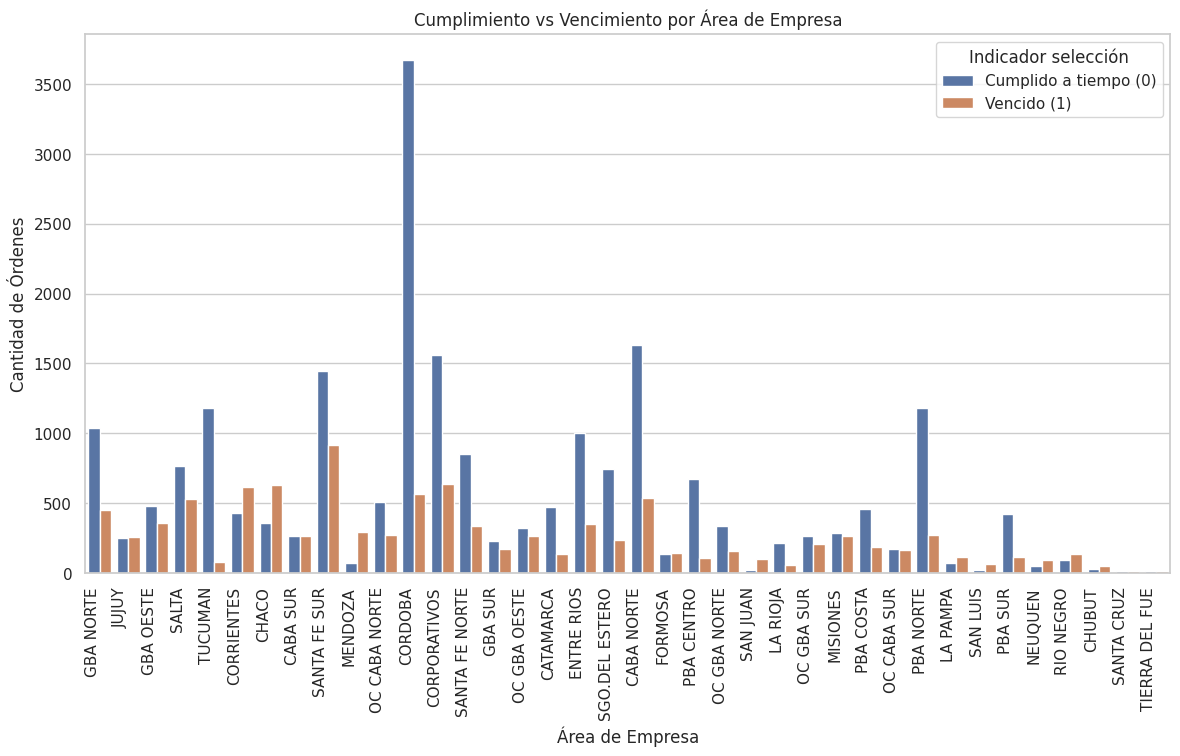

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo de los gráficos
sns.set(style="whitegrid")

# Gráfico de barras para el cumplimiento/vencimiento por Área de Empresa
plt.figure(figsize=(14, 7))
sns.countplot(data=df, x='Descripción del Area de Empresa', hue='Indicador selección')
plt.title('Cumplimiento vs Vencimiento por Área de Empresa')
plt.xlabel('Área de Empresa')
plt.ylabel('Cantidad de Órdenes')
plt.xticks(rotation=90, ha="right")
plt.legend(title='Indicador selección', loc='upper right', labels=['Cumplido a tiempo (0)', 'Vencido (1)'])
plt.show()


#Gráfico de Barras para Ver la Distribución de Cumplimiento/Vencimiento según la Prioridad
Este gráfico te ayudará a entender cómo los diferentes niveles de prioridad afectan el cumplimiento o vencimiento de las órdenes.

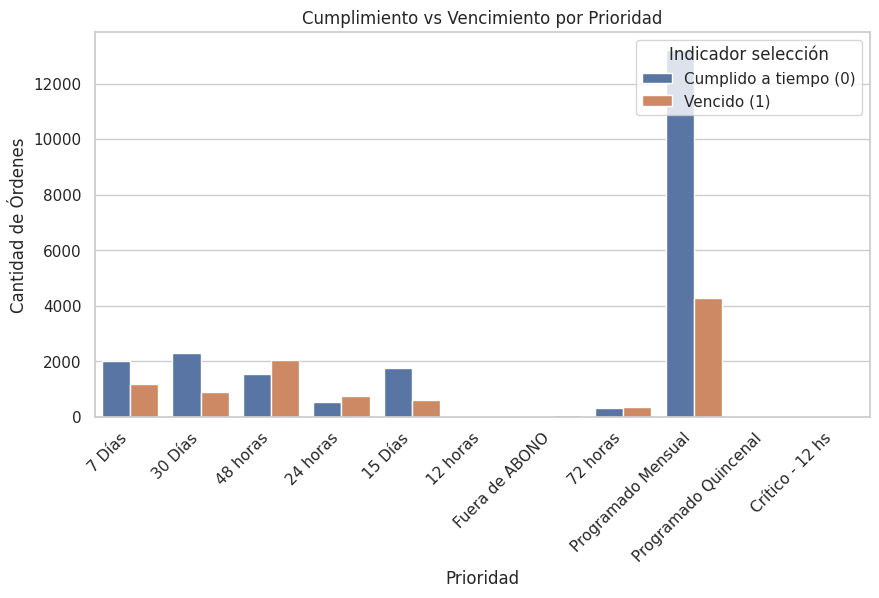

In [5]:
# Gráfico de barras para el cumplimiento/vencimiento por Prioridad
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Descripción de la Prioridad', hue='Indicador selección')
plt.title('Cumplimiento vs Vencimiento por Prioridad')
plt.xlabel('Prioridad')
plt.ylabel('Cantidad de Órdenes')
plt.xticks(rotation=45, ha="right")
plt.legend(title='Indicador selección', loc='upper right', labels=['Cumplido a tiempo (0)', 'Vencido (1)'])
plt.show()


#Gráfico de Caja (Boxplot) para Ver la Distribución del Tiempo de Ejecución según el Cumplimiento/Vencimiento
Los gráficos de caja pueden mostrar cómo varía el tiempo de ejecución entre las órdenes cumplidas a tiempo y las vencidas.

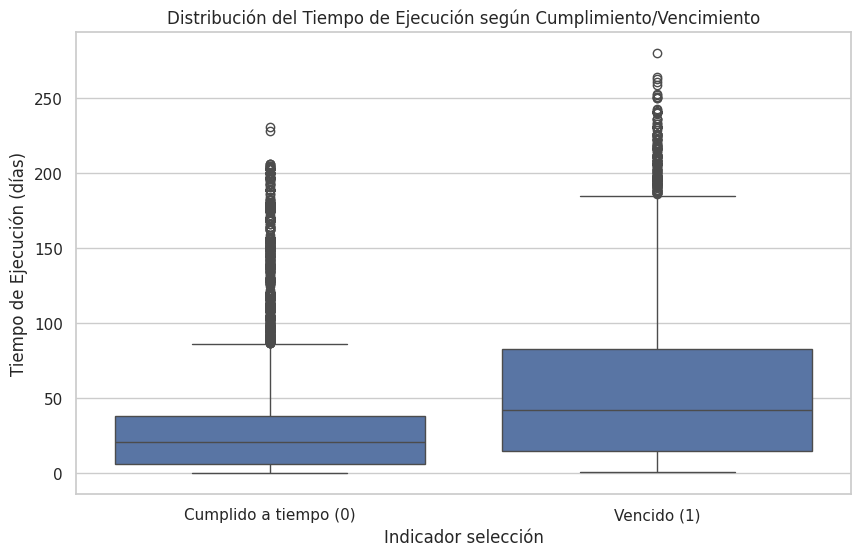

In [6]:
# Gráfico de caja para el tiempo de ejecución según el cumplimiento/vencimiento
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Indicador selección', y='Tiempo_ejecucion')
plt.title('Distribución del Tiempo de Ejecución según Cumplimiento/Vencimiento')
plt.xlabel('Indicador selección')
plt.ylabel('Tiempo de Ejecución (días)')
plt.xticks([0, 1], ['Cumplido a tiempo (0)', 'Vencido (1)'])
plt.show()


# Mapa de Calor para Ver la Correlación entre las Variables Numéricas
El mapa de calor es útil para visualizar la correlación entre las diferentes variables numéricas, incluyendo el indicador de cumplimiento.

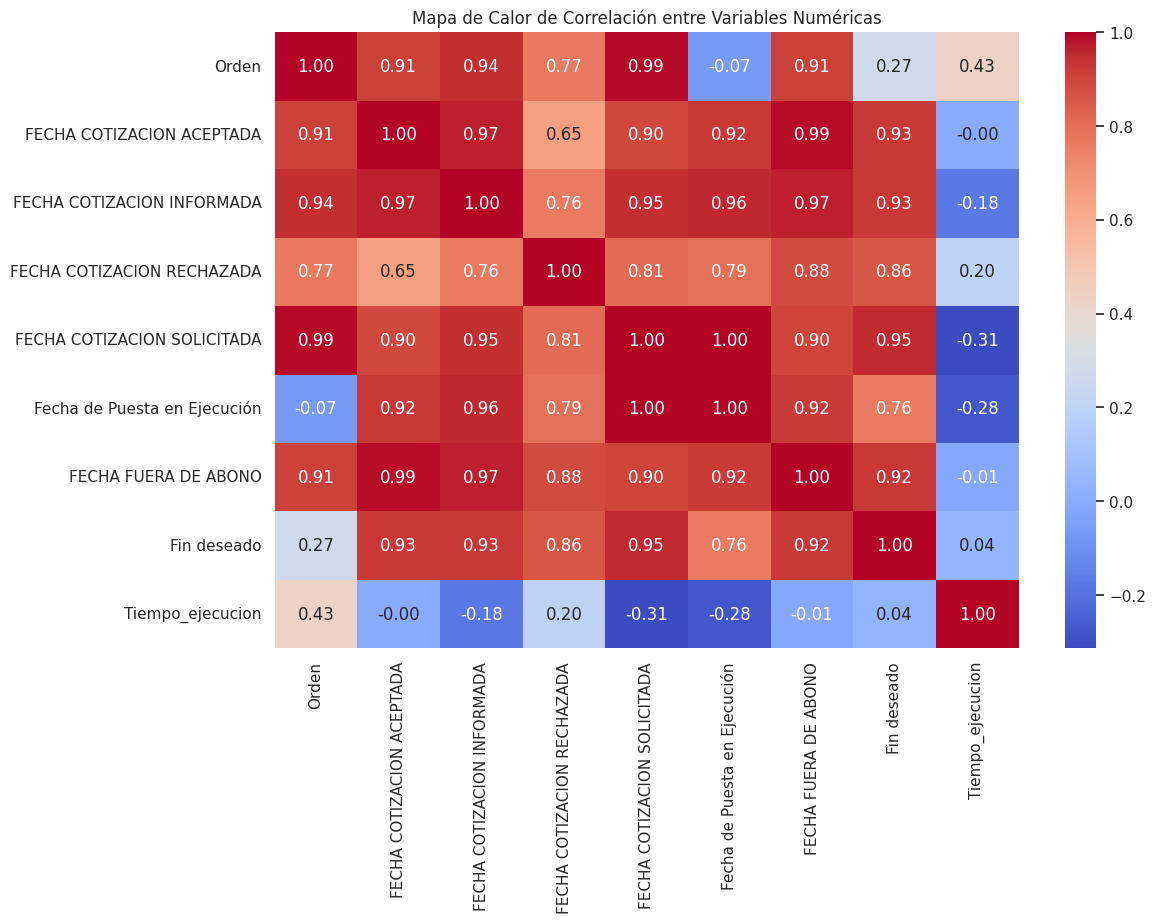

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar solo las columnas numéricas
df_numeric = df.select_dtypes(include=['float64', 'int64'])

# Crear un mapa de calor para ver las correlaciones entre las variables numéricas
plt.figure(figsize=(12, 8))
correlation_matrix = df_numeric.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de Calor de Correlación entre Variables Numéricas')
plt.show()


# Gráfico de Barras para la Distribución de Cumplimiento/Vencimiento según el Tipo de Actividad
Para entender la influencia de los diferentes tipos de actividades en el cumplimiento o vencimiento de las órdenes:

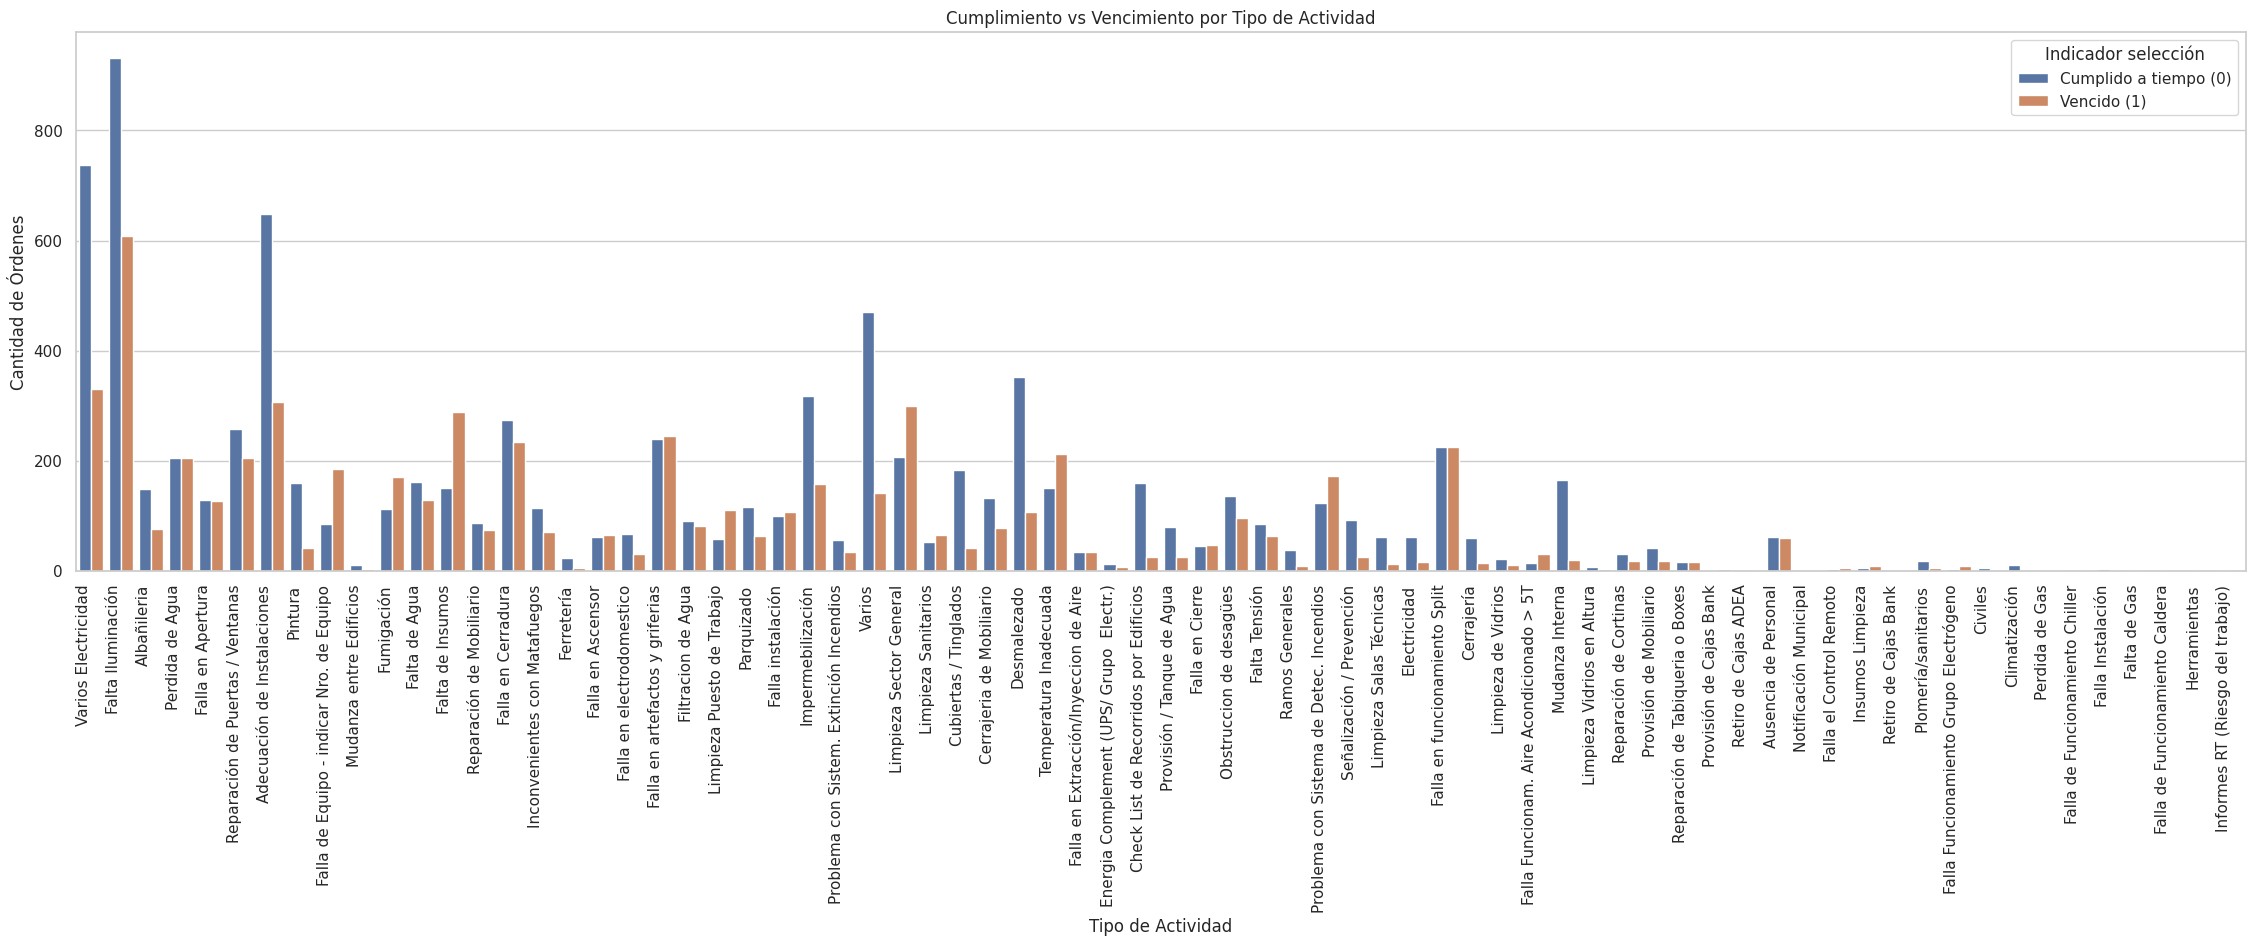

In [8]:
# Gráfico de barras para el cumplimiento/vencimiento por Tipo de Actividad
plt.figure(figsize=(28, 7))
sns.countplot(data=df, x='Descripción del Código', hue='Indicador selección')
plt.title('Cumplimiento vs Vencimiento por Tipo de Actividad')
plt.xlabel('Tipo de Actividad')
plt.ylabel('Cantidad de Órdenes')
plt.xticks(rotation=90, ha="right")
plt.legend(title='Indicador selección', loc='upper right', labels=['Cumplido a tiempo (0)', 'Vencido (1)'])
plt.show()


#Entrenamiento Modelo ML y Rendimiento

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# 1. Cargar los datos
data = pd.read_csv('Historial_OT.csv', encoding='latin1', delimiter=';')

# 2. Seleccionar las columnas relevantes para el modelo
columns = ['Descripción del Grupo de Planificación', 'Descripción de la Clase de Actividad PM',
           'Área de empresa', 'Descripción del Grupo de Códigos',
           'Descripción del Código', 'Descripción Clase de Orden',
           'Descrip. del Puesto de Trabajo Resp.', 'Descripción de la Prioridad',
           'Descripción de la Ubicación / Centro', 'Descripción de la Ubicación Técnica',
           'Indicador selección']

# 3. Crear un DataFrame con las columnas seleccionadas
df = data[columns].copy()

# 4. Convertir los valores de 'Indicador selección' ('+' a 0 y '-' a 1)
df['Indicador selección'] = df['Indicador selección'].apply(lambda x: 1 if x == '-' else 0)

# 5. Eliminar filas con datos NaN
df.dropna(inplace=True)

# 6. Convertir las variables categóricas en variables numéricas utilizando codificación one-hot
df = pd.get_dummies(df, drop_first=True)

# 7. Separar las características (X) y la variable objetivo (y)
X = df.drop(columns=['Indicador selección'])
y = df['Indicador selección']

# 8. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 9. Crear y entrenar un modelo RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 10. Realizar predicciones con los datos de prueba
y_pred = model.predict(X_test)

# 11. Evaluar el rendimiento del modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.785958904109589
ROC AUC Score: 0.7769735188308132

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.84      0.82      2009
           1       0.77      0.72      0.74      1495

    accuracy                           0.79      3504
   macro avg       0.78      0.78      0.78      3504
weighted avg       0.79      0.79      0.78      3504

